In [41]:
# Constants

RAW_DATA_FILES_PATH = "data"
OUTPUT_LABEL = "PM2.5 (µg/m³)"
PM10 = "PM10 (µg/m³)"

In [2]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.axes as pltaxes
import matplotlib.pyplot as plt
import regex

In [29]:
dataset = pd.read_csv(os.path.join(RAW_DATA_FILES_PATH, "2019.csv"))
aqi_df = pd.read_csv("aqi_levels.csv")

In [30]:
dataset.head()

,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),...,WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s),Month,Date,Festival,Festival_Name
0,2019-01-01 00:00:00,313.968571,424.79300,125.440833,62.944167,116.227143,56.976,13.033571,1.662857,11.218571,...,95.811667,0.0,0.0,10.385833,832.315833,NaN,1,1,True,New Year
1,2019-01-01 01:00:00,324.452143,440.62900,116.475833,61.730833,109.737857,61.844,13.277500,1.989167,9.440000,...,98.981667,0.0,0.0,10.415833,832.235000,NaN,1,1,True,New Year
2,2019-01-01 02:00:00,316.057143,434.88800,142.742000,60.972500,110.983571,58.916,12.306667,1.344286,12.436667,...,105.957500,0.0,0.0,10.713333,832.165000,NaN,1,1,True,New Year
3,2019-01-01 03:00:00,304.890000,440.80625,146.989000,62.885833,114.212143,56.146,11.182500,1.572857,13.931000,...,100.542500,0.0,0.0,10.260833,832.023333,NaN,1,1,True,New Year
4,2019-01-01 04:00:00,286.830714,420.62125,144.520000,51.044167,107.585714,58.978,10.959167,1.445714,12.259167,...,99.990000,0.0,0.0,10.842500,831.681667,NaN,1,1,True,New Year


In [31]:
aqi_df.head()

,AQI_Low,AQI_High,Feature,Feature_Low,Feature_High
0,0,50,PM2.5 (µg/m³),0.0,30.0
1,51,100,PM2.5 (µg/m³),31.0,60.0
2,101,200,PM2.5 (µg/m³),61.0,90.0
3,201,300,PM2.5 (µg/m³),91.0,120.0
4,301,400,PM2.5 (µg/m³),121.0,250.0


In [37]:
aqi_features = aqi_df['Feature'].unique().tolist()

In [33]:
aqi_df.groupby('Feature')

In [47]:
# get each and then pass it to the function to get max sub index aqi -> (max aqi, sub index feature name)
x = dataset.iloc[0:24,:]

In [48]:
x.head()

,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),...,WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s),Month,Date,Festival,Festival_Name
0,2019-01-01 00:00:00,313.968571,424.79300,125.440833,62.944167,116.227143,56.976,13.033571,1.662857,11.218571,...,95.811667,0.0,0.0,10.385833,832.315833,NaN,1,1,True,New Year
1,2019-01-01 01:00:00,324.452143,440.62900,116.475833,61.730833,109.737857,61.844,13.277500,1.989167,9.440000,...,98.981667,0.0,0.0,10.415833,832.235000,NaN,1,1,True,New Year
2,2019-01-01 02:00:00,316.057143,434.88800,142.742000,60.972500,110.983571,58.916,12.306667,1.344286,12.436667,...,105.957500,0.0,0.0,10.713333,832.165000,NaN,1,1,True,New Year
3,2019-01-01 03:00:00,304.890000,440.80625,146.989000,62.885833,114.212143,56.146,11.182500,1.572857,13.931000,...,100.542500,0.0,0.0,10.260833,832.023333,NaN,1,1,True,New Year
4,2019-01-01 04:00:00,286.830714,420.62125,144.520000,51.044167,107.585714,58.978,10.959167,1.445714,12.259167,...,99.990000,0.0,0.0,10.842500,831.681667,NaN,1,1,True,New Year


In [100]:
aqi_groups = {feature: group for feature, group in aqi_df.groupby("Feature")}

In [101]:
def calculate_sub_index(concentration, pollutent):
    df = aqi_groups.get(pollutent)
    y = df.loc[
        (df["Feature_Low"] <= concentration) & (df["Feature_High"] >= concentration)
    ]
    if y.empty:
        return np.nan
    aqi_lower = y["AQI_Low"].values[0]
    aqi_upper = y["AQI_High"].values[0]
    lower = y["Feature_Low"].values[0]
    upper = y["Feature_High"].values[0]
    aqi = aqi_lower + ((aqi_upper - aqi_lower) / (upper - lower)) * (
        concentration - lower
    )
    return np.round(aqi)

In [102]:
def calculate_aqi_for_hour(df, pollutant):
    df[f"{pollutant}_AQI"] = df[pollutant].apply(
        lambda x: calculate_sub_index(x, pollutant)
    )
    return df

In [103]:
def calculate_ovreall_aqi(df):
    for pollutant in aqi_features:
        df = calculate_aqi_for_hour(df, pollutant)

    aqi_columns = [f"{pollutant}_AQI" for pollutant in aqi_features]
    df["Overall_AQI"] = df[aqi_columns].max(axis=1)

    df["Highest_Sub_Index"] = df[aqi_columns].idxmax(axis=1).str.replace("_AQI", "")
    return df

In [108]:
for filename in os.listdir(RAW_DATA_FILES_PATH):
    match = re.match(regex.YEAR_FILE_PATTERN, filename)
    if match:
        df = pd.read_csv(os.path.join(RAW_DATA_FILES_PATH, filename))
        df = calculate_ovreall_aqi(df)
        df.to_csv(os.path.join(RAW_DATA_FILES_PATH, filename), index=False)

In [111]:
for filename in os.listdir(RAW_DATA_FILES_PATH):
    match = re.match(regex.YEAR_ALL_REGION_FILE_PATTERN, filename)
    if match:
        df = pd.read_csv(os.path.join(RAW_DATA_FILES_PATH, filename))
        df = calculate_ovreall_aqi(df)
        df.to_csv(os.path.join(RAW_DATA_FILES_PATH, filename), index=False)

C:\Users\vikas\AppData\Local\Temp\ipykernel_20188\3353292562.py:8: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["Highest_Sub_Index"] = df[aqi_columns].idxmax(axis=1).str.replace("_AQI", "")
C:\Users\vikas\AppData\Local\Temp\ipykernel_20188\3353292562.py:8: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["Highest_Sub_Index"] = df[aqi_columns].idxmax(axis=1).str.replace("_AQI", "")
C:\Users\vikas\AppData\Local\Temp\ipykernel_20188\3353292562.py:8: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["Highest_Sub_Index"] = df[aqi_columns].idxmax(axis=1).str.replace("_AQI", "")
C:\Users\vikas\AppData\Local\Temp\ipykernel_20188\3353292562.py:8: FutureWar

### AQI Graphs

In [157]:
plt.style.use("default")

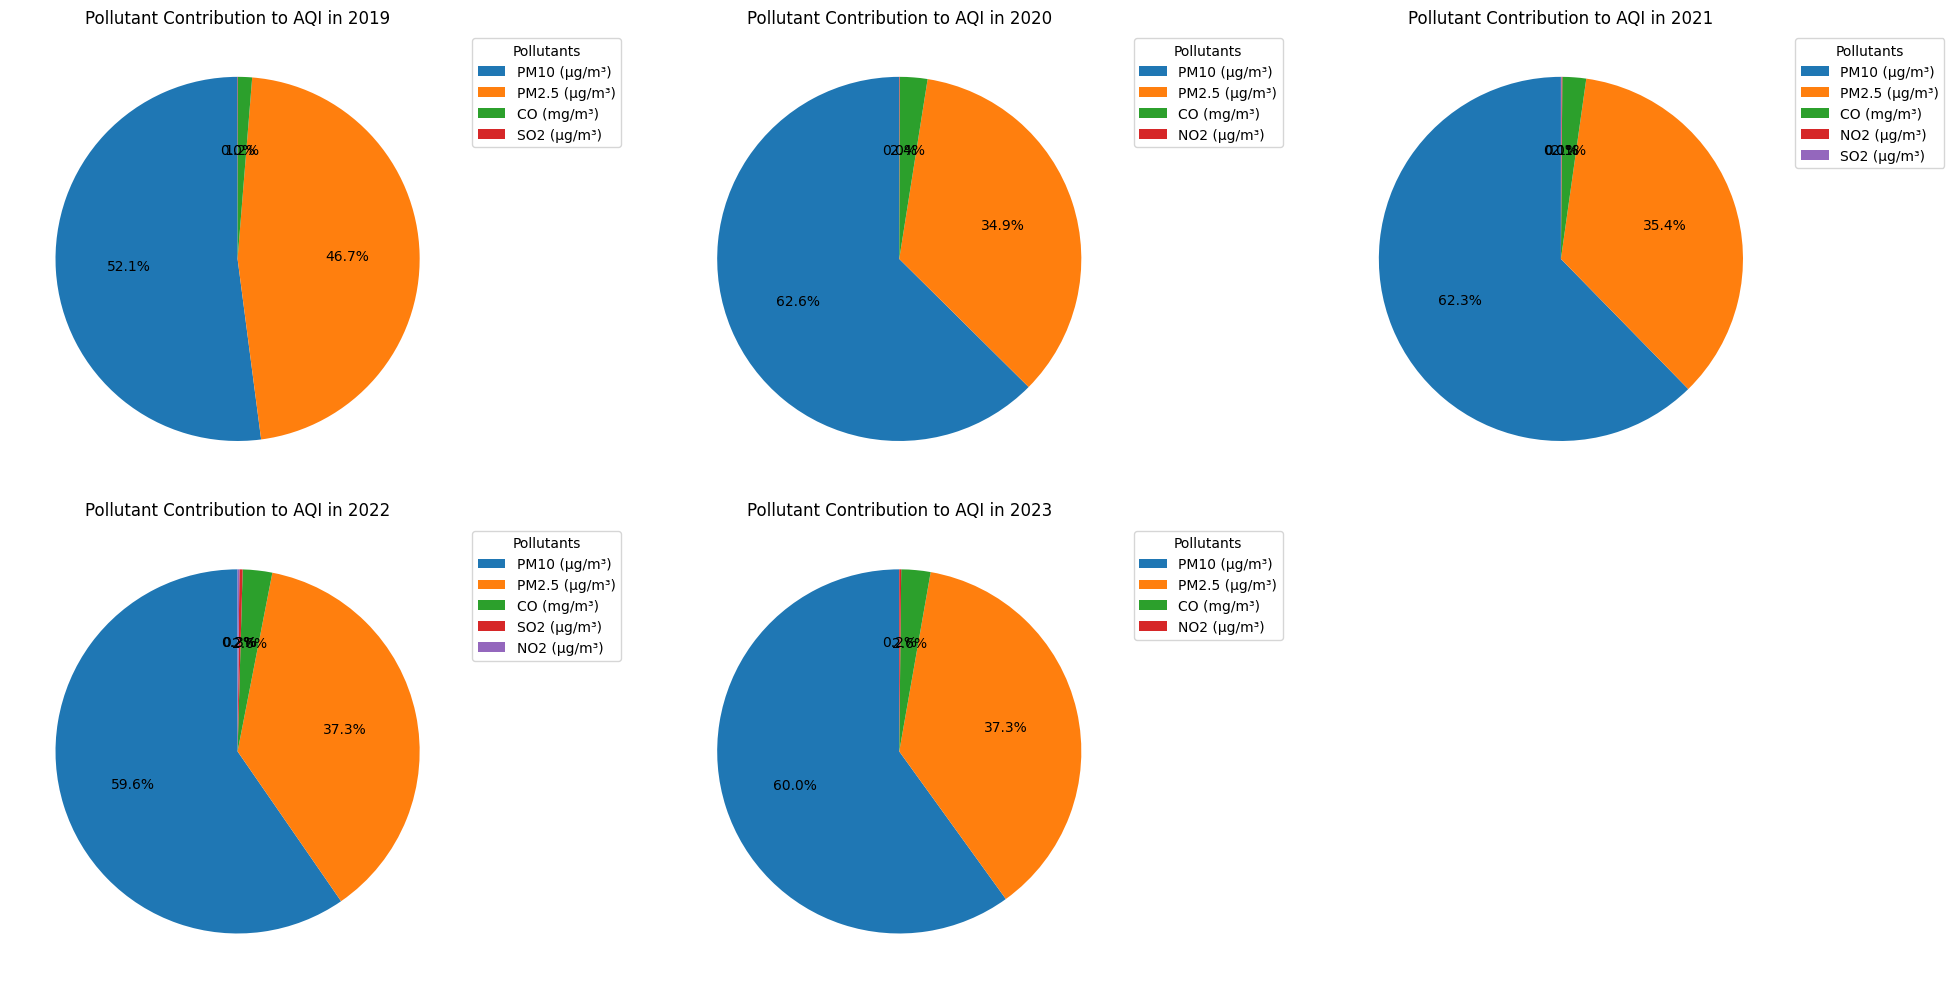

In [158]:
col = 3
row = 2
fig, axes = plt.subplots(row, col, figsize=(20, 10))
axes = axes.flatten()

for i, year in enumerate(range(2019, 2024)):
    df = pd.read_csv(os.path.join(RAW_DATA_FILES_PATH, f"{year}.csv"))
    counts = df["Highest_Sub_Index"].value_counts()
    counts.plot.pie(
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.tab10.colors,
        labeldistance=None,
        ax=axes[i],
    )

    axes[i].set_title(f"Pollutant Contribution to AQI in {year}")
    axes[i].set_ylabel("")
    axes[i].legend(counts.index, title="Pollutants", bbox_to_anchor=(1, 1))

for j in range(i + 1, row * col):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [159]:
# pie chart showing most contributing pollutant in 2019 for all regions
dataset = pd.read_csv(os.path.join(RAW_DATA_FILES_PATH, "2019.csv"))

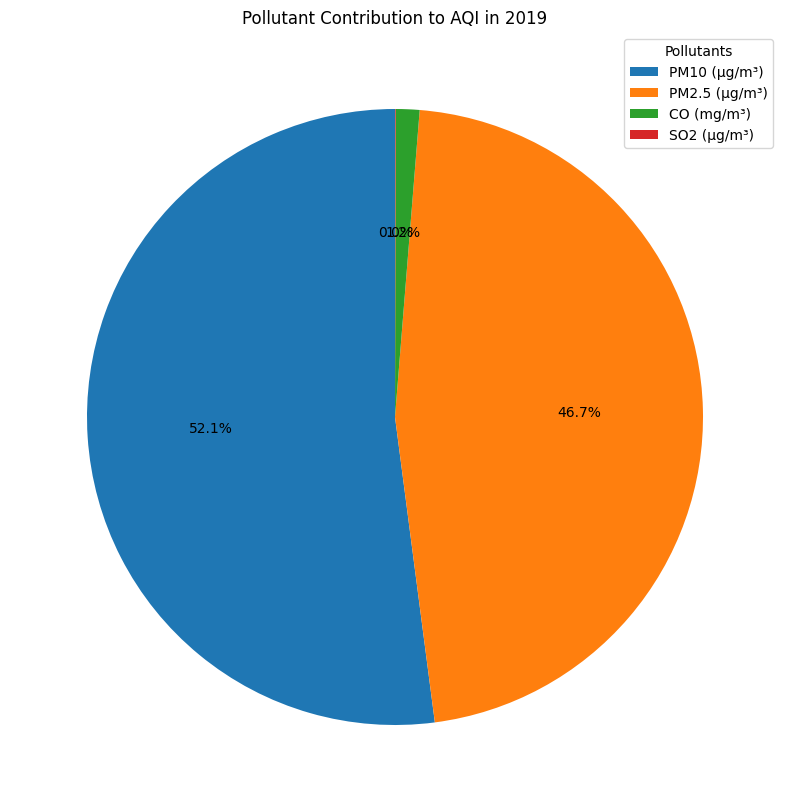

In [160]:
counts = dataset["Highest_Sub_Index"].value_counts()

plt.figure(figsize=(10, 10))
counts.plot.pie(
    autopct="%1.1f%%", startangle=90, colors=plt.cm.tab10.colors, labeldistance=None
)

plt.title("Pollutant Contribution to AQI in 2019")
plt.ylabel("")
plt.legend(counts.index, title="Pollutants", bbox_to_anchor=(1, 1))
plt.show()

In [161]:
df_2022 = pd.read_csv(os.path.join(RAW_DATA_FILES_PATH, "2022_all_regions.csv"))

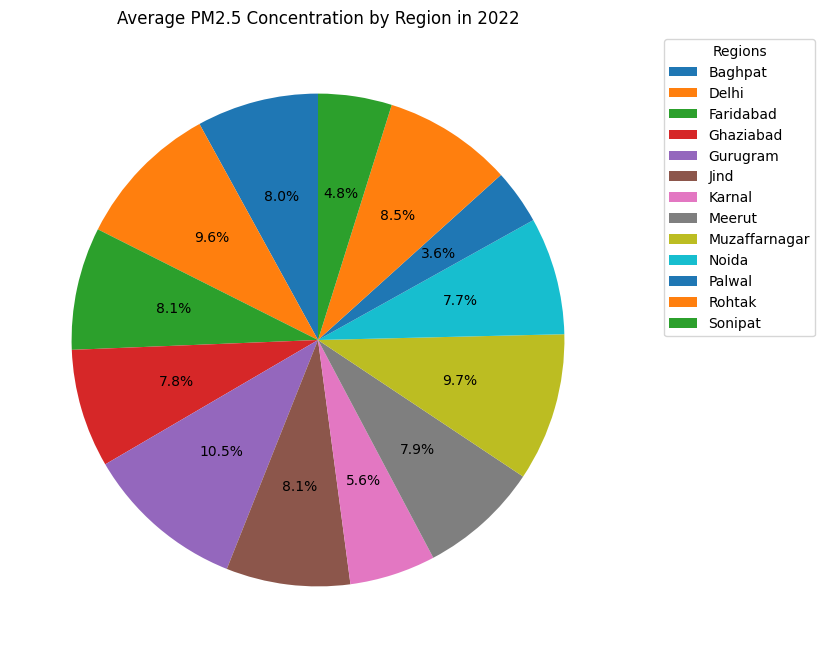

In [163]:
grouped_2022 = df_2022.groupby("Region")[OUTPUT_LABEL].mean()
grouped_2022.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(8, 8),
    startangle=90,
    colors=plt.cm.tab10.colors,
    labeldistance=None,
    legend=True
)

plt.title("Average PM2.5 Concentration by Region in 2022")
plt.ylabel("")
plt.legend(grouped_2022.index, title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [164]:
region_groups = df_2022.groupby("Region")

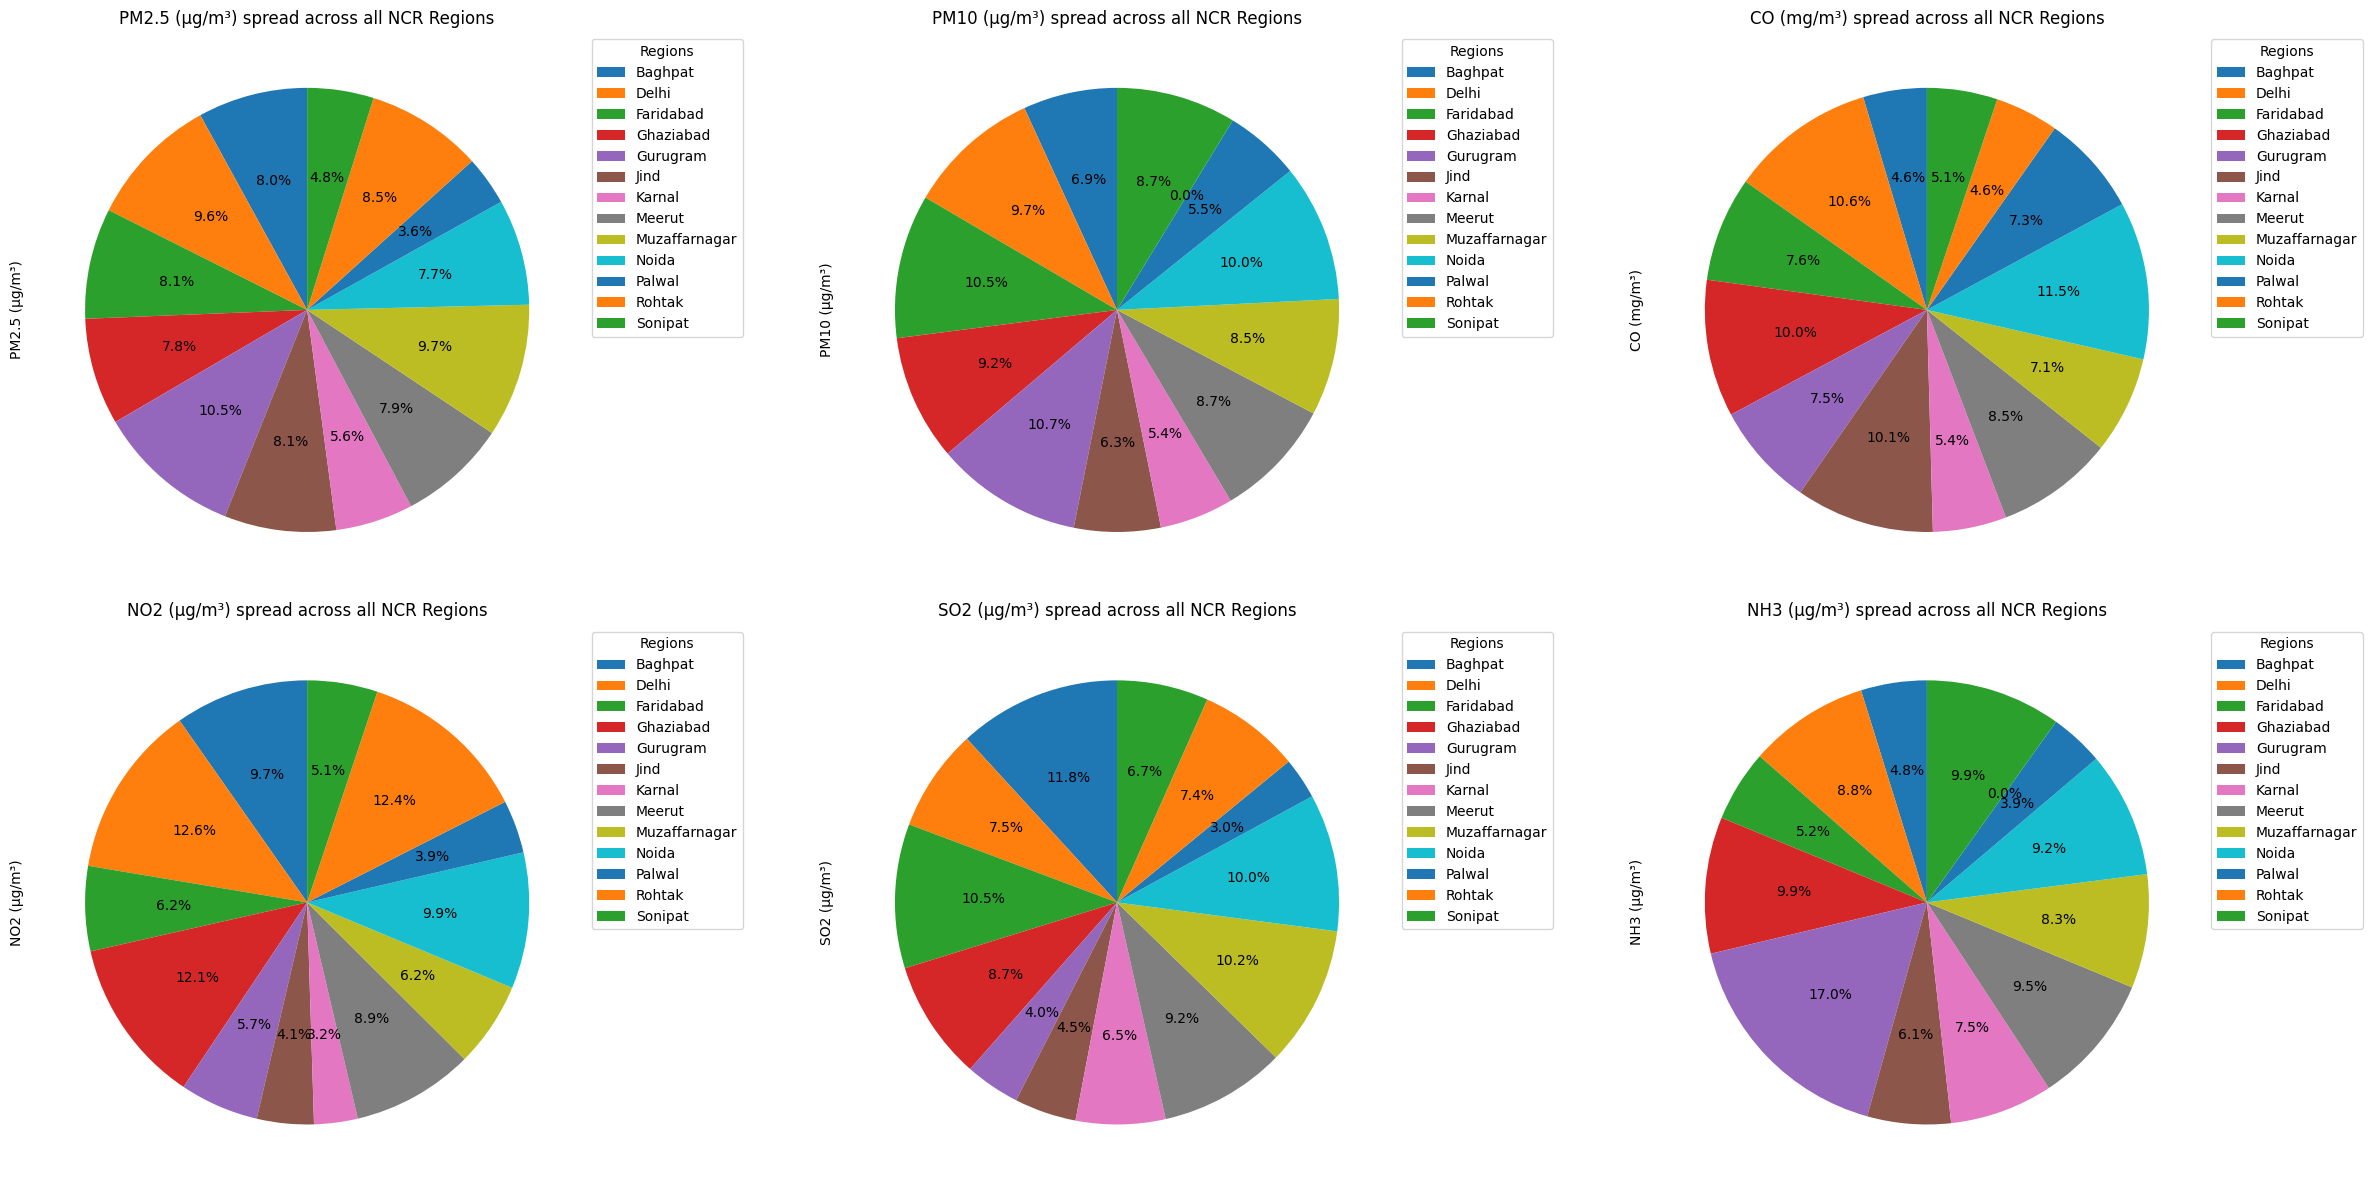

In [166]:
row = 2
col = 3

fig, axes = plt.subplots(row, col, figsize=(25, 12))
axes = axes.flatten()

for i, pollutant in enumerate(aqi_features):
    counts = region_groups[pollutant].mean()
    counts.plot.pie(
        autopct="%1.1f%%",
        startangle=90,
        colors=plt.cm.tab10.colors,
        labeldistance=None,
        ax=axes[i],
    )
    axes[i].set_title(f"{pollutant} spread across all NCR Regions")
    axes[i].set_ylabel(pollutant)
    axes[i].legend(counts.index, title="Regions", bbox_to_anchor=(1, 1))

for j in range(i + 1, len(aqi_features)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()